In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm, theano.tensor as tt

In [2]:
%matplotlib inline

### What's the Point of Practicing Penalties?

What if we wanted to rank MLS penalty kickers? What would be the best way to go about it?

We could look at historical PKs, and take the players who have converted the highest percentage of their chances. Let's load in our data to do that:

In [3]:
penalties = pd.read_csv('mls_pks_11_to_17.csv')
penalties.head()

,date,time,shooter,team,keeper,opposition,result,home_team,away_team,home_score,away_score,goal,on_target,save
0,3/7/2015,89:42:00,Jozy Altidore,Toronto,David Ousted,Vancouver,Goal,Vancouver,Toronto,1,2,1,1,0
1,3/9/2015,24:36:00,Clint Dempsey,Seattle,Bobby Shuttleworth,New England,Goal,Seattle,New England,0,0,1,1,0
2,3/15/2015,85:57:00,Alvaro Saborio,Salt Lake,Rais M'bolhi,Philadelphia,Goal,Salt Lake,Philadelphia,2,3,1,1,0
3,3/15/2015,78:56:00,Dominic Dwyer,Kansas City,Chris Seitz,FC Dallas,Saved,FC Dallas,Kansas City,3,1,0,1,1
4,3/22/2015,91:01:00,Chris Pontius,DC United,Luis Robles,New York,Miss,New York,DC United,2,0,0,0,0


And let's get data frames rolled up to the shooter and to the keeper level.

In [4]:
shooters = penalties.groupby('shooter').goal.agg(['sum', 'mean', 'size']).reset_index()
shooters.columns = ['shooter', 'goals', 'proportion', 'attempts']
shooters.head()

,shooter,goals,proportion,attempts
0,Alberth Elis,1,1.000000,1
1,Alejandro Bedoya,0,0.000000,1
2,Alvaro Fernandez,1,0.500000,2
3,Alvaro Saborio,13,0.866667,15
4,Andre Akpan,1,1.000000,1


In [6]:
keepers = penalties.groupby('keeper').goal.agg(['sum', 'mean', 'size']).reset_index()
keepers.columns = ['keeper', 'goals', 'proportion', 'attempts']
keepers.sort_values('proportion').head()

,keeper,goals,proportion,attempts
69,Stefan Marinovic,0,0.0,1
60,Milos Kocic,0,0.0,1
47,Jon Kempin,0,0.0,3
19,Carlo Cudicini,0,0.0,1
15,Brad Stuver,0,0.0,1


Here are a handful a players who have scored 100% of their regular season penalties, going back to 2011:

Octavio Rivero, Victor Bernardez, Danny Cruz, Servando Carrasco, Shaun Maloney, Gonzalo Pineda, Brek Shea, Hendry Thomas

Raise your hand if you want Victor Bernardez taking your team's PKs.

We could also incorporate number of attempts each player has taken, and use that as a tie-breaker for players with the same percentages. Here are the ten best shooters using that method:

In [7]:
shooters.sort_values(['proportion', 'attempts'], ascending=False)[0:10]

,shooter,goals,proportion,attempts
7,Benny Feilhaber,12,1.0,12
12,Brad Evans,9,1.0,9
18,Camilo Da Silva Sanvezzo,7,1.0,7
117,Michel Garbini Pereira,6,1.0,6
160,Vicente Sanchez,6,1.0,6
5,Andres Mendoza,5,1.0,5
16,C.J. Sapong,4,1.0,4
34,Daniel Royer,4,1.0,4
38,David Accam,4,1.0,4
68,Giovani dos Santos,4,1.0,4


The top looks a bit better, but what about the players at the bottom:

In [8]:
shooters.sort_values(['proportion', 'attempts'], ascending=False)[-10:]

,shooter,goals,proportion,attempts
115,Michael Bradley,0,0.0,1
116,Michael Farfan,0,0.0,1
128,Omar Cummings,0,0.0,1
137,Rafael Marquez,0,0.0,1
144,Ryan Johnson,0,0.0,1
147,Sal Zizzo,0,0.0,1
155,Steven Gerrard,0,0.0,1
156,Terry Dunfield,0,0.0,1
158,Thierry Henry,0,0.0,1
159,Torsten Frings,0,0.0,1


Do we really believe Michael Bradley and Thierry Henry are worse than Ryan Finley, a man who somehow managed to be entrusted with two penalties in just 800 total MLS minutes? And what about Steven Gerrard, whose only attempt came against Nick Rimando and his fantastic 47% success rate?

We can use Bayesian inference, and, more specifically here, [Item Response Theory](https://en.wikipedia.org/wiki/Item_response_theory), to get at each player's true propensity to score penalties in a bit more nuanced and comprehensive way than looking only at his historic totals. To put it informally, with Bayesian inference we begin an analysis with some hypothesis about each player's true penalty scoring ability, and we update that hypothesis as we see additional data. There is some good precendent for using this sort of approach to measure scoring ability. See [here](https://statsbomb.com/2017/07/quantifying-finishing-skill/) and [here](http://www.optasportspro.com/about/optapro-blog/posts/2017/blog-re-examining-finishing-skill/) for two excellent articles. (I'm applying the method below specifically to shots from the penalty spot, but, with a few tweaks and considerations, it can be applied more widely. Stay tuned.)

Using an Item Response Theory framework, I'll model the probability, $p_k$, of penalty $k$ going in  as a function of a shooter $i$'s latent penalty taking ability, $\theta_i$, and a goalkeeper $j$'s latent penalty stopping ability, $b_j$. (See [here](http://austinrochford.com/posts/2017-04-04-nba-irt.html) for a fantastic piece that uses IRT to model NBA late game fouls, from which I borrow heavily.)

That is:

$$
\begin{align*}
\eta_k &= \theta_i - b_j
\newline
p_k &= \frac{1}{1 + \exp(-\eta_k)}
\end{align*}
$$

Here the higher the penalty taker's ability, $\theta_i$, the more likely the shot will go in. The higher the keeper's ability, $b_j$, the less likely the shot will go in.

Including an effect for the goalkeeper, while making the model more true to reality, also has the added effect of giving us an estimate of goalie ability simultaneously. I should note though that I'm still crediting off-target shots to the keeper as a save. This might not be wholly accurate, but I think if you squint hard enough the case could be made that a goalie's positioning, or size, or intimidation can factor into off-target penalties.

We'll define our prior beliefs on $\theta$ and $b$ as below:

$$
\begin{align*}
\mu_\theta &\sim N(0, 100)
\newline
\sigma_\theta &\sim \mathrm{HalfStudentT(3,\ 2.5)}
\newline
\theta_i &\sim N(\mu_\theta,\ \sigma_\theta)
\newline
\newline
\sigma_b &\sim \mathrm{HalfStudentT(3,\ 2.5)}
\newline
b_j &\sim N(0,\ \sigma_b)
\end{align*}
$$

To do that with our code, let's first first initialize some other values we'll need:

In [9]:
# define the shape of our scale parameters
n_shooters = shooters.shape[0]
n_keepers = keepers.shape[0]

In [10]:
# be able to index our shooters
shooters['shooter_id'] = range(n_shooters)
keepers['keeper_id'] = range(n_keepers)

In [11]:
# tack on those id's to our by shot data
penalties = pd.merge(penalties, shooters, on='shooter')
penalties = pd.merge(penalties, keepers, on='keeper')

In [12]:
# pull the lists of importance out
shooter_id = penalties.shooter_id.values
keeper_id = penalties.keeper_id.values
outcome = penalties.goal

Here's where we actually define the model:

In [13]:
with pm.Model() as irt_model:
    mu_theta = pm.Normal('mu_theta', 0., 10.)
    delta_theta = pm.Normal('delta_theta', 0., 1., shape=n_shooters)
    sigma_theta = pm.HalfStudentT('sigma_theta', nu=3, sd=2.5)
    theta = pm.Deterministic('theta', mu_theta + delta_theta * sigma_theta)
    
    delta_b = pm.Normal('delta_b', 0., 1., shape=n_keepers)
    sigma_b = pm.HalfStudentT('sigma_b', nu=3, sd=2.5)
    b = pm.Deterministic('b', 0 + delta_b * sigma_b)

In [14]:
with irt_model:
    eta = theta[shooter_id] - b[keeper_id]
    p = pm.Deterministic('p', pm.math.sigmoid(eta))
    y = pm.Bernoulli('y_obs', p, observed=outcome)

Using [MCMC sampling](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo), we can incorporate the data we have on each shooter and keeper to update those prior beliefs into what is more or less our best estimate of the latent ability of each shooter and each keeper.

In [15]:
with irt_model:
        irt_trace = pm.sample(4000, tune=2000, random_seed=1112)[2000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 6000/6000 [00:44<00:00, 134.71it/s]


Let's take a look at an energyplot to get an idea of whether we have sampling issues:

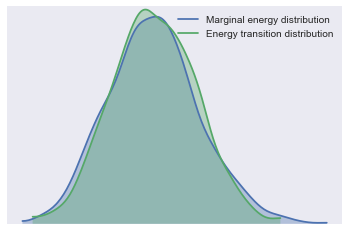

In [16]:
pm.energyplot(irt_trace)

Looks pretty good.

Now we've got our posteriors, let's look at what we actually care about, some credible intervals for the best and worst penalty takers (highest and lowest average $\theta$'s).

First, some code to pull out the necessary values from our trace (borrowed from the IRT post linked above).

In [18]:
def to_param_df(player_df, trace, varnames, id_column):
    df = player_df
    
    for name in varnames:
        mean = trace[name].mean(axis=0)
        low, high = np.percentile(trace[name], [5, 95], axis=0)
        
        df = df.assign(**{
            '{}_mean'.format(name): mean[df[id_column]],
            '{}_low'.format(name): low[df[id_column]],
            '{}_high'.format(name): high[df[id_column]]
        })
        
    return df

In [19]:
theta_df = to_param_df(shooters, irt_trace, ['theta'], 'shooter_id')
theta_df.head()

,shooter,goals,proportion,attempts,shooter_id,theta_high,theta_low,theta_mean
0,Alberth Elis,1,1.000000,1,0,1.762119,0.917951,1.320619
1,Alejandro Bedoya,0,0.000000,1,1,1.684209,0.824510,1.273567
2,Alvaro Fernandez,1,0.500000,2,2,1.718528,0.814800,1.277663
3,Alvaro Saborio,13,0.866667,15,3,1.809901,1.023062,1.366652
4,Andre Akpan,1,1.000000,1,4,1.811113,0.909917,1.335542


Here are those intervals for the ten best and ten worst penalty shooters as determined by the model:

In [21]:
top_ten = theta_df.sort_values('theta_mean', ascending=False)[0:10]
bottom_ten = theta_df.sort_values('theta_mean', ascending=False)[-10:]
to_plot = pd.concat([top_ten, bottom_ten], axis=0).iloc[::-1]

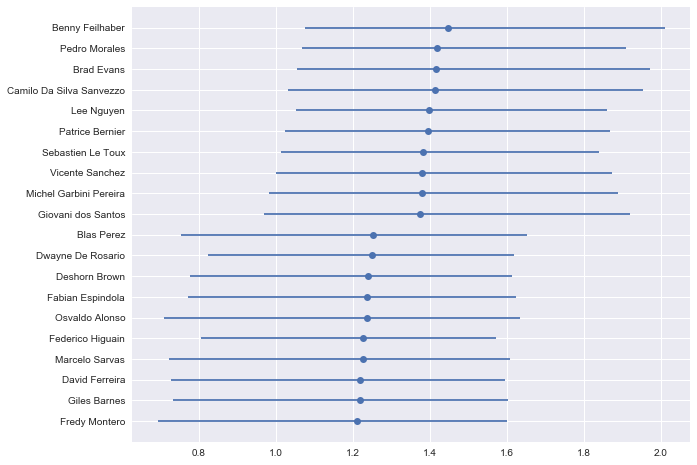

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.errorbar(to_plot.theta_mean.values,
            np.arange(20),
            xerr=np.row_stack([[to_plot.theta_mean.values - to_plot.theta_low.values, to_plot.theta_high.values - to_plot.theta_mean.values]]),
            fmt='o')
ax.set_ylim(-1, 20)
ax.set_yticks(np.arange(20))
ax.set_yticklabels(to_plot.shooter);

So Benny Feilhaber is pretty good. Giles Barnes, maybe not so much. The main thing to note, though, is that, even among the, as far as we can tell, ten best and ten worst penalty takers, there's a ton of overlap between our estimate of their abilities. Based on the data we have available, there's just not much discernible difference between the best and the worst.

It's tangential to the point I want to make, but let's look at the ten best and ten worst goalies at saving penalty kicks.

In [20]:
b_df = to_param_df(keepers, irt_trace, ['b'], 'keeper_id')
b_df.head()

,keeper,goals,proportion,attempts,keeper_id,b_high,b_low,b_mean
0,Adam Larsen Kwarasey,5,1.000000,5,0,0.426604,-0.818693,-0.149351
1,Alec Kann,5,1.000000,5,1,0.457070,-0.797095,-0.138976
2,Alex Bono,1,1.000000,1,2,0.601764,-0.684857,-0.038674
3,Alexander Bono,3,0.600000,5,3,0.804830,-0.459913,0.115828
4,Andre Blake,5,0.714286,7,4,0.734117,-0.553345,0.064716


In [24]:
top_ten = b_df.sort_values('b_mean', ascending=False)[0:10]
bottom_ten = b_df.sort_values('b_mean', ascending=False)[-10:]
to_plot = pd.concat([top_ten, bottom_ten], axis=0).iloc[::-1]

Here are the credible intervals for those keepers:

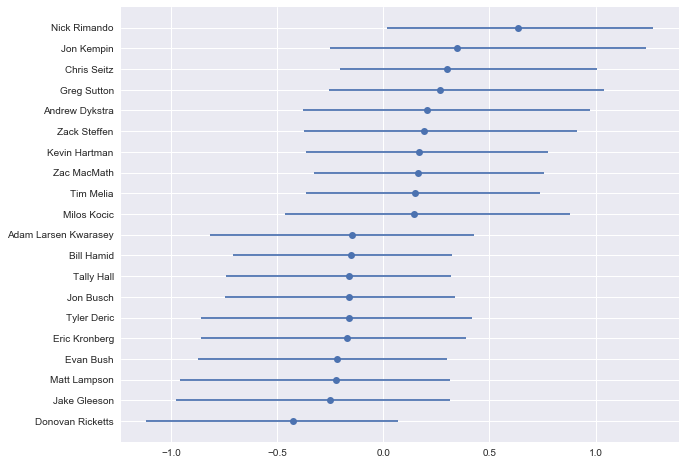

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.errorbar(to_plot.b_mean.values,
            np.arange(20),
            xerr=np.row_stack([[to_plot.b_mean.values - to_plot.b_low.values, to_plot.b_high.values - to_plot.b_mean.values]]),
            fmt='o')
ax.set_ylim(-1, 20)
ax.set_yticks(np.arange(20))
ax.set_yticklabels(to_plot.keeper);

There's a bit more spread among keepers, where we have more data per keeper. Nick Rimando is clearly very good. Donovan Ricketts is more likely bad. Jake Gleeson isn't great either. The Timbers sure know how to pick 'em. Given his recent playoff heroics it's affirming to see Zach Steffen pop up highly without that playoff data included.

To conclude, and summarize my main point again, because of small sample sizes it's very difficult to determine between good and poor penalty shooters only using the data that’s available from games. This is quite a lot of math to make a fairly intuitive point, but I already had half an article written with the math, and I’m going to come back to the method at a later date.